# Importing Required Libraries

In [1]:
#python libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from google.colab import drive  
import gzip

#Sklearn libraries
from sklearn.cluster import KMeans
from sklearn.metrics import  normalized_mutual_info_score, adjusted_rand_score, silhouette_score
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

#neural networks libraries
from tensorflow import keras
import tensorflow as tf 
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.layers import Dense, Input, Layer, InputSpec
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import VarianceScaling

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/HPC Dataset

/content/drive/MyDrive/HPC Dataset


In [4]:
!pwd

/content/drive/MyDrive/HPC Dataset


# 1. Loading Dataset

In [5]:
df = pd.read_parquet('/content/drive/MyDrive/HPC Dataset/r206n05.gzip')

In [6]:
df = df.drop(['label','timestamp'],axis=1)

In [7]:
df.head()

,avg:ambient,var:ambient,max:ambient,min:ambient,avg:dimm0_temp,var:dimm0_temp,max:dimm0_temp,min:dimm0_temp,avg:dimm10_temp,var:dimm10_temp,max:dimm10_temp,min:dimm10_temp,avg:dimm11_temp,var:dimm11_temp,max:dimm11_temp,min:dimm11_temp,avg:dimm12_temp,var:dimm12_temp,max:dimm12_temp,min:dimm12_temp,avg:dimm13_temp,var:dimm13_temp,max:dimm13_temp,min:dimm13_temp,avg:dimm14_temp,var:dimm14_temp,max:dimm14_temp,min:dimm14_temp,avg:dimm15_temp,var:dimm15_temp,max:dimm15_temp,min:dimm15_temp,avg:dimm1_temp,var:dimm1_temp,max:dimm1_temp,min:dimm1_temp,avg:dimm2_temp,var:dimm2_temp,max:dimm2_temp,min:dimm2_temp,...,var:mem_free,max:mem_free,min:mem_free,avg:mem_shared,var:mem_shared,max:mem_shared,min:mem_shared,avg:mem_total,var:mem_total,max:mem_total,min:mem_total,avg:part_max_used,var:part_max_used,max:part_max_used,min:part_max_used,avg:pkts_in,var:pkts_in,max:pkts_in,min:pkts_in,avg:pkts_out,var:pkts_out,max:pkts_out,min:pkts_out,avg:proc_run,var:proc_run,max:proc_run,min:proc_run,avg:proc_total,var:proc_total,max:proc_total,min:proc_total,avg:swap_free,var:swap_free,max:swap_free,min:swap_free,avg:swap_total,var:swap_total,max:swap_total,min:swap_total,New_label
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
27,21.353846,0.101026,21.8,20.8,30.076923,0.076923,31,30,29.0,0.0,29,29,28.230769,0.192308,29,28,29.384615,0.256410,30,29,29.0,0.0,29,29,28.615385,0.256410,29,28,30.000000,0.000000,30,30,31.0,0.0,31,31,31.000000,0.000000,31,31,...,4.953429e+06,286699392.0,286695168.0,0,0.0,0,0,329873088.0,0.0,329873088.0,329873088.0,27.5,0.0,27.5,27.5,566.60,73.6898,572.67,560.53,41.420,200.00000,51.42,31.42,4.0,0.0,4,4,2031.666667,1.333333,2033,2031,3593600.0,0.0,3593600,3593600,4194240,0.0,4194240,4194240,0
30,21.384615,0.189744,22.0,20.8,30.230769,0.192308,31,30,29.0,0.0,29,29,28.615385,0.256410,29,28,30.000000,0.000000,30,30,29.0,0.0,29,29,29.000000,0.000000,29,29,30.000000,0.000000,30,30,31.0,0.0,31,31,31.000000,0.000000,31,31,...,4.066111e+08,286697344.0,286648000.0,0,0.0,0,0,329873088.0,0.0,329873088.0,329873088.0,27.5,0.0,27.5,27.5,586.96,0.0000,586.96,586.96,50.270,0.00000,50.27,50.27,4.0,0.0,4,4,2033.666667,9.333333,2037,2031,3593702.4,1228.8,3593728,3593664,4194240,0.0,4194240,4194240,0
33,21.169231,0.078974,21.6,20.8,30.000000,0.000000,30,30,29.0,0.0,29,29,28.230769,0.192308,29,28,29.769231,0.192308,30,29,29.0,0.0,29,29,28.538462,0.269231,29,28,30.000000,0.000000,30,30,31.0,0.0,31,31,31.000000,0.000000,31,31,...,1.374549e+06,286703296.0,286700864.0,0,0.0,0,0,329873088.0,0.0,329873088.0,329873088.0,27.5,0.0,27.5,27.5,568.65,0.0000,568.65,568.65,34.590,0.00000,34.59,34.59,4.0,0.0,4,4,2032.500000,0.333333,2033,2032,3593792.0,0.0,3593792,3593792,4194240,0.0,4194240,4194240,0
36,21.615385,0.083077,22.0,21.0,30.384615,0.256410,31,30,29.0,0.0,29,29,28.846154,0.141026,29,28,29.769231,0.192308,30,29,29.0,0.0,29,29,28.692308,0.230769,29,28,30.000000,0.000000,30,30,31.0,0.0,31,31,31.000000,0.000000,31,31,...,1.168766e+08,286701248.0,286681664.0,0,0.0,0,0,329873088.0,0.0,329873088.0,329873088.0,27.5,0.0,27.5,27.5,566.66,658.1192,584.80,548.52,48.075,703.50005,66.83,29.32,4.0,0.0,4,4,2034.666667,4.333333,2037,2033,3593920.0,0.0,3593920,3593920,4194240,0.0,4194240,4194240,0
39,21.153846,0.174359,21.8,20.6,30.000000,0.000000,30,30,29.0,0.0,29,29,28.230769,0.192308,29,28,29.923077,0.076923,30,29,29.0,0.0,29,29,28.923077,0.076923,29,28,30.076923,0.076923,31,30,31.0,0.0,31,31,30.846154,0.141026,31,30,...,2.609152e+06,286705088.0,286701888.0,0,0.0,0,0,329873088.0,0.0,329873088.0,329873088.0,27.5,0.0,27.5,27.5,571.60,0.0000,571.60,571.60,31.840,0.00000,31.84,31.84,4.0,0.0,4,4,2032.333333,14.333333,2035,2028,3593984.0,0.0,3593984,3593984,4194240,0.0,4194240,4194240,0


# 2. Data Preprocessing  

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15310 entries, 27 to 96192
Columns: 461 entries, avg:ambient to New_label
dtypes: float64(265), int64(196)
memory usage: 54.0 MB


In [9]:
df.shape

(15310, 461)

In [10]:
df.describe()

,avg:ambient,var:ambient,max:ambient,min:ambient,avg:dimm0_temp,var:dimm0_temp,max:dimm0_temp,min:dimm0_temp,avg:dimm10_temp,var:dimm10_temp,max:dimm10_temp,min:dimm10_temp,avg:dimm11_temp,var:dimm11_temp,max:dimm11_temp,min:dimm11_temp,avg:dimm12_temp,var:dimm12_temp,max:dimm12_temp,min:dimm12_temp,avg:dimm13_temp,var:dimm13_temp,max:dimm13_temp,min:dimm13_temp,avg:dimm14_temp,var:dimm14_temp,max:dimm14_temp,min:dimm14_temp,avg:dimm15_temp,var:dimm15_temp,max:dimm15_temp,min:dimm15_temp,avg:dimm1_temp,var:dimm1_temp,max:dimm1_temp,min:dimm1_temp,avg:dimm2_temp,var:dimm2_temp,max:dimm2_temp,min:dimm2_temp,...,var:mem_free,max:mem_free,min:mem_free,avg:mem_shared,var:mem_shared,max:mem_shared,min:mem_shared,avg:mem_total,var:mem_total,max:mem_total,min:mem_total,avg:part_max_used,var:part_max_used,max:part_max_used,min:part_max_used,avg:pkts_in,var:pkts_in,max:pkts_in,min:pkts_in,avg:pkts_out,var:pkts_out,max:pkts_out,min:pkts_out,avg:proc_run,var:proc_run,max:proc_run,min:proc_run,avg:proc_total,var:proc_total,max:proc_total,min:proc_total,avg:swap_free,var:swap_free,max:swap_free,min:swap_free,avg:swap_total,var:swap_total,max:swap_total,min:swap_total,New_label
count,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.00000,15310.000000,15310.000000,15310.000000,15310.000000,...,1.531000e+04,1.531000e+04,1.531000e+04,15310.0,15310.0,15310.0,15310.0,1.531000e+04,1.531000e+04,1.531000e+04,1.531000e+04,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,1.531000e+04,15310.000000,15310.000000,15310.000000,1.531000e+04,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,1.531000e+04,1.531000e+04,1.531000e+04,1.531000e+04,15310.0,15310.0,15310.0,15310.0,15310.000000
mean,18.716309,0.041324,18.940888,18.489288,27.082400,0.073318,27.264533,26.897257,27.616306,0.062888,27.770020,27.456303,26.746158,0.059816,26.899282,26.593730,28.284319,0.054541,28.422142,28.146636,28.036971,0.052043,28.171718,27.900457,27.282826,0.055404,27.425082,27.134553,29.144904,0.054030,29.277335,29.011626,27.727007,0.073613,27.907838,27.54337,27.455028,0.073310,27.631287,27.269040,...,1.702010e+14,2.722686e+08,2.620881e+08,0.0,0.0,0.0,0.0,3.298712e+08,8.551199e+10,3.298729e+08,3.298686e+08,30.804193,0.000049,30.804226,30.804128,128.873508,5.442567e+05,161.338372,108.027613,93.567569,5.659367e+05,133.210568,69.797506,18.704123,121.751347,22.564925,14.915088,2466.528028,201.218219,2471.037818,2461.721816,3.586335e+06,5.954080e+08,3.587052e+06,3.585617e+06,4194240.0,0.0,4194240.0,4194240.0,0.049510
std,2.482816,0.097875,2.505538,2.466572,2.421890,0.142473,2.452004,2.409420,2.378890,0.161412,2.419428,2.357913,2.311058,0.136461,2.343664,2.293094,2.355177,0.143016,2.394726,2.335975,2.310773,0.125796,2.335887,2.298973,2.335523,0.121861,2.366062,2.322556,2.446185,0.157551,2.482053,2.427496,2.392586,0.154271,2.435650,2.37184,2.369092,0.151518,2.403587,2.363289,...,7.508565e+14,4.666930e+07,5.896779e+07,0.0,0.0,0.0,0.0,2.135554e+05,1.058070e+13,4.534989e+02,5.338899e+05,3.002500,0.006061,3.002478,3.002561,445.783245,6.620769e+07,1290.093192,130.641526,436.820203,6.625271e+07,1323.881179,46.737991,27.852179,605.891266,32.445941,25.781654,553.608159,2000.095383,553.419675,554.162798,4.641056e+05,2.908237e+10,4.617490e+05,4.674183e+05,0.0,0.0,0.0,0.0,0.310766
min,10.426667,0.000000,10.600000,10.000000,20.266667,0.000000,21.000000,20.000000,20.000000,0.000000,20.000000,20.000000,19.000000,0.000000,19.000000,19.000000,20.666667,0.000000,21.000000,20.000000,20.400000,0.000000,21.00000

In [11]:
df.isnull().sum()

avg:ambient       0
var:ambient       0
max:ambient       0
min:ambient       0
avg:dimm0_temp    0
                 ..
avg:swap_total    0
var:swap_total    0
max:swap_total    0
min:swap_total    0
New_label         0
Length: 461, dtype: int64

# 2.2 Splitting the Data into X and Y

In [12]:
X = df.drop('New_label',axis=1)
y = df.New_label

In [13]:
y = y.apply(lambda x: 1 if x == 2 else 0)

In [14]:
y = y.values

# 2.3 Scaling Features

In [15]:
columns = list(X.columns.values)
scaler = MinMaxScaler() 
X[columns] = scaler.fit_transform(X[columns])
X.head()

,avg:ambient,var:ambient,max:ambient,min:ambient,avg:dimm0_temp,var:dimm0_temp,max:dimm0_temp,min:dimm0_temp,avg:dimm10_temp,var:dimm10_temp,max:dimm10_temp,min:dimm10_temp,avg:dimm11_temp,var:dimm11_temp,max:dimm11_temp,min:dimm11_temp,avg:dimm12_temp,var:dimm12_temp,max:dimm12_temp,min:dimm12_temp,avg:dimm13_temp,var:dimm13_temp,max:dimm13_temp,min:dimm13_temp,avg:dimm14_temp,var:dimm14_temp,max:dimm14_temp,min:dimm14_temp,avg:dimm15_temp,var:dimm15_temp,max:dimm15_temp,min:dimm15_temp,avg:dimm1_temp,var:dimm1_temp,max:dimm1_temp,min:dimm1_temp,avg:dimm2_temp,var:dimm2_temp,max:dimm2_temp,min:dimm2_temp,...,avg:mem_free,var:mem_free,max:mem_free,min:mem_free,avg:mem_shared,var:mem_shared,max:mem_shared,min:mem_shared,avg:mem_total,var:mem_total,max:mem_total,min:mem_total,avg:part_max_used,var:part_max_used,max:part_max_used,min:part_max_used,avg:pkts_in,var:pkts_in,max:pkts_in,min:pkts_in,avg:pkts_out,var:pkts_out,max:pkts_out,min:pkts_out,avg:proc_run,var:proc_run,max:proc_run,min:proc_run,avg:proc_total,var:proc_total,max:proc_total,min:proc_total,avg:swap_free,var:swap_free,max:swap_free,min:swap_free,avg:swap_total,var:swap_total,max:swap_total,min:swap_total
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
27,0.738323,0.023489,0.756757,0.710526,0.770439,0.017445,0.833333,0.769231,0.645933,0.0,0.6,0.692308,0.702850,0.033654,0.714286,0.692308,0.653846,0.037033,0.642857,0.642857,0.668394,0.0,0.571429,0.692308,0.676014,0.051775,0.692308,0.642857,0.608696,0.00000,0.533333,0.642857,0.770408,0.0,0.769231,0.785714,0.779412,0.000000,0.769231,0.785714,...,0.874903,3.562865e-10,0.874379,0.875723,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.010236,8.995324e-09,0.003387,0.757637,0.000717,2.440156e-08,0.000303,0.020416,0.028777,0.0,0.015625,0.030303,0.308851,0.000013,0.304531,0.309848,0.856535,0.000000e+00,0.856224,0.856794,0.0,0.0,0.0,0.0
30,0.740402,0.044117,0.770270,0.710526,0.782521,0.043612,0.833333,0.769231,0.645933,0.0,0.6,0.692308,0.732136,0.044872,0.714286,0.692308,0.700000,0.000000,0.642857,0.714286,0.668394,0.0,0.571429,0.692308,0.704433,0.000000,0.692308,0.714286,0.608696,0.00000,0.533333,0.642857,0.770408,0.0,0.769231,0.785714,0.779412,0.000000,0.769231,0.785714,...,0.874851,2.924642e-08,0.874372,0.875568,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.010626,0.000000e+00,0.003478,0.793361,0.000886,0.000000e+00,0.000296,0.032664,0.028777,0.0,0.015625,0.030303,0.309630,0.000089,0.306068,0.309848,0.856560,6.695233e-10,0.856254,0.856809,0.0,0.0,0.0,0.0
33,0.725849,0.018362,0.743243,0.710526,0.764398,0.000000,0.750000,0.769231,0.645933,0.0,0.6,0.692308,0.702850,0.033654,0.714286,0.692308,0.682692,0.027775,0.642857,0.642857,0.668394,0.0,0.571429,0.692308,0.670330,0.054364,0.692308,0.642857,0.608696,0.00000,0.533333,0.642857,0.770408,0.0,0.769231,0.785714,0.779412,0.000000,0.769231,0.785714,...,0.874921,9.886755e-11,0.874392,0.875742,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.010276,0.000000e+00,0.003361,0.768612,0.000586,0.000000e+00,0.000196,0.022476,0.028777,0.0,0.015625,0.030303,0.309175,0.000003,0.304531,0.310237,0.856581,0.000000e+00,0.856270,0.856840,0.0,0.0,0.0,0.0
36,0.755994,0.019316,0.770270,0.723684,0.794603,0.058149,0.833333,0.769231,0.645933,0.0,0.6,0.692308,0.749707,0.024679,0.714286,0.692308,0.682692,0.027775,0.642857,0.642857,0.668394,0.0,0.571429,0.692308,0.681698,0.046598,0.692308,0.642857,0.608696,0.00000,0.533333,0.642857,0.770408,0.0,0.769231,0.785714,0.779412,0.000000,0.769231,0.785714,...,0.874876,8.406614e-09,0.874385,0.875679,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.010238,8.033670e-08,0.003464,0.741404,0.000844,8.583250e-08,0.000401,0.019051,0.028777,0.0,0.015625,0.030303,0.310019,0.000042,0.306068,0.310627,0.856612,0.000000e+00,0.856300,0.856870,0.0,0.0,0.0,0.0
39,0.724809,0.040540,0.756757,0.697368,0.764398,0.000000,0.750000,0.769231,0.645933,0.0,0.6,0.692308,0.702850,0.033654,0.714286,0.692308,0.694231,0.011110,0.642857,0.642857,0.66839

# 3. Models

## 3.1 Baseline model 
## K-means

In [ ]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters)
y_pred_kmeans = kmeans.fit_predict(X)

# Evaluation

## Clustering Accuracy

In [25]:
def cluster_accuracy(y_pred,y_true):
  D = max(y_pred.max(), y_true.max()) + 1
  w = np.zeros((D, D), dtype=np.int64)
  # Confusion matrix
  for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
  ind = linear_assignment(-w)
  acc = sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size
  return acc

In [ ]:
cluster_accuracy(y_pred_kmeans,y)

0.7224689745264533

## Silhoutte Score

In [ ]:
score = silhouette_score(X, y_pred_kmeans, metric='euclidean')
print ("For n_clusters = {}, K_means silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, K_means silhouette score is 0.4166513420465401)


## Baseline model-2 : Gaussian Mixture Model 

In [17]:
GMM = GaussianMixture(n_components=2, random_state=42)
y_pred_b2 = GMM.fit_predict(X)

###Evaluation

In [18]:
cluster_accuracy(y_pred_b2,y)

0.5243631613324624

In [21]:
score = silhouette_score(X, y_pred_b2, metric='euclidean')
print ("For n_clusters = {}, GMM silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, GMM silhouette score is 0.18864048238995582)


##Baseline model-3: Agglomerative Clustering

In [22]:
aggcl = AgglomerativeClustering(n_clusters=2, affinity='euclidean')
y_pred_b3 = aggcl.fit_predict(X)

###Evaluation

In [34]:
cluster_accuracy(y_pred_b2,y)

0.5243631613324624

In [35]:
score = silhouette_score(X, y_pred_b3, metric='euclidean')
print ("For n_clusters = {}, Agglomerative Clustering silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, GMM silhouette score is 0.41874138702518476)


# 3.2 Autoencoder Model


In [ ]:
def auto_encoder(dims, init):
    stack_layers = len(dims) - 1
    
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    
    # internal layers of encoder
    for i in range(stack_layers-1):
        x = Dense(dims[i + 1], activation='relu',  kernel_initializer=init, name='encoder_%d' % i)(x)

    # latent hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (stack_layers - 1))(x)
    x = encoded

    # internal layers of decoder
    for i in range(stack_layers-1, 0, -1):
        x = Dense(dims[i], activation='relu', kernel_initializer=init, name='decoder_%d' % i)(x)

    # decoder output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    
    decoded = x
    
    autoencoder_model = Model(inputs=input_data, outputs=decoded, name='autoencoder')
    encoder_model = Model(inputs=input_data, outputs=encoded, name='encoder')
    
    return autoencoder_model, encoder_model

In [ ]:
#No of Clusters
n_clusters = 2
#dimensions
dims = [X.shape[-1], 500, 500, 2000, 10]
#Pre_trained Optimizer
optimizer = SGD(learning_rate=0.1, momentum=0.9)
#initialization
init =  tf.keras.initializers.RandomNormal(mean=0,stddev=0.01)

In [ ]:
autoencoder, encoder = auto_encoder(dims, init=init)

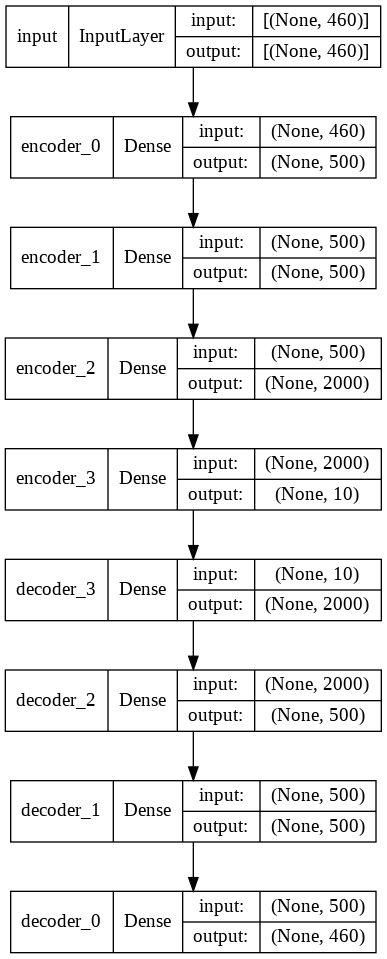

In [ ]:
plot_model(autoencoder,show_shapes=True)

In [ ]:
path = '/content/drive/My Drive/HPC Dataset/results'

In [ ]:
autoencoder.compile(optimizer=optimizer, loss='mse')
#call_back = keras.callbacks.EarlyStopping(monitor='loss',patience=5) 
autoencoder.fit(X, X, batch_size=128, epochs=100,verbose=1)
autoencoder.save_weights(path + '/ae_weights_dimred_10d.h5')

Epoch 1/100
120/120 [==============================] - 1s 5ms/step - loss: 0.1208
Epoch 2/100
120/120 [==============================] - 0s 4ms/step - loss: 0.0375
Epoch 3/100
120/120 [==============================] - 0s 4ms/step - loss: 0.0303
Epoch 4/100
120/120 [==============================] - 0s 4ms/step - loss: 0.0303
Epoch 5/100
120/120 [==============================] - 0s 4ms/step - loss: 0.0303
Epoch 6/100
120/120 [==============================] - 0s 4ms/step - loss: 0.0303
Epoch 7/100
120/120 [==============================] - 0s 4ms/step - loss: 0.0303
Epoch 8/100
120/120 [==============================] - 0s 4ms/step - loss: 0.0303
Epoch 9/100
120/120 [==============================] - 0s 4ms/step - loss: 0.0303
Epoch 10/100
120/120 [==============================] - 0s 4ms/step - loss: 0.0303
Epoch 11/100
120/120 [==============================] - 0s 4ms/step - loss: 0.0302
Epoch 12/100
120/120 [==============================] - 0s 4ms/step - loss: 0.0303
Epoch 13/100


In [ ]:
embedded_data = encoder.predict(X)

In [ ]:
embedded_data.shape

(15310, 10)

#  3.3 K-Means 

In [ ]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters)
y_pred1 = kmeans.fit_predict(embedded_data)

##Evaluation

In [ ]:
acc = cluster_accuracy(y_pred=y_pred1,y_true=y)
print(acc)

0.735532331809275


In [ ]:
score = silhouette_score(X, y_pred1, metric='euclidean')
print ("For n_clusters = {}, K_means silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, K_means silhouette score is 0.42106060617556507)


# 3.4 Gaussian Mixture Model

In [ ]:
GMM = GaussianMixture(n_components=2, random_state=42)
y_pred2 = GMM.fit_predict(embedded_data)

## Evaluation

In [ ]:
acc = cluster_accuracy(y_pred=y_pred3,y_true=y)
print(acc)

0.7370999346832136

In [ ]:
score = silhouette_score(X, y_pred2, metric='euclidean')
print ("For n_clusters = {}, K_means silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, K_means silhouette score is 0.4201211867168033)


# 3.5 Agglomerative Clustering

In [ ]:
aggcl = AgglomerativeClustering(n_clusters=2, affinity='euclidean')
y_pred3 = aggcl.fit_predict(embedded_data)

## Evaluation

In [ ]:
acc = cluster_accuracy(y_pred=y_pred3,y_true=y)
print(acc)

0.7628347485303723

In [ ]:
score = silhouette_score(X, y_pred3, metric='euclidean')
print ("For n_clusters = {}, K_means silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, K_means silhouette score is 0.42296811226245756)
